In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 60
pd.options.display.max_rows = 500
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import os

In [2]:
# Es posible que deba instalar el siguiente modulo

import unidecode

# Para ello, una vez instalado pip (https://phoenixnap.com/kb/install-pip-windows) se puede correr en una terminal:

# pip install unidecode

# asegurarse que la carpeta unidecode esta en el PATH donde python lee los modulos.
# Ej. anaconda3/lib/site-packages


## Funciones crear cuadro resumen

In [3]:
def cuadro_resumen_por_area(data, grouper = ['Q','Region','NOMAGLO']):

    # Individuos
        # pobreza n, pct
        # indigencia n, pct
        
        
    df = data.groupby(grouper)[['Pobreza', 'Indigencia']].agg(
        {'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum']})

    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac/1e3).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac/1e3).round(1)#.astype(int)
    df[[('Pobreza', 'mean')]] = 100*df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = 100*df[[('Indigencia', 'mean')]].round(4)
    
    dfA = df.T.set_index(np.repeat('Personas', df.shape[1]), append=True).T

    # Mayores
        # ingresos mean, median
    df = data.loc[data.P03 > 24].groupby(grouper)[['Pobreza', 'Indigencia','P47T_persona']].agg(
        {'Pobreza': 'mean', 'Indigencia': 'mean', 'P47T_persona':['mean', 'median']})
    df[[('Pobreza', 'mean')]] = 100*df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = 100*df[[('Indigencia', 'mean')]].round(4)
    df['P47T_persona'] = df['P47T_persona'].round(-2).astype(int)    
    dfB = df.T.set_index(np.repeat('Mayores de 24', df.shape[1]), append=True).T

    # Hogares
        # pobreza n, pct
        # indigencia n, pct
        # ingresos mean, median
        # CBA, mean median
        # CBT, mean median
        # gap, mean median
    df = data.groupby('HOGAR_REF_ID').first().groupby(grouper)[['Pobreza', 'Indigencia', 'P47T_hogar', 'CBA', 'CBT', 'gap']].agg(
    {'Pobreza': ['mean', 'sum'], 'Indigencia': ['mean', 'sum'], 'P47T_hogar': ['mean', 'median'],
     'CBA': ['mean', 'median'],  'CBT': ['mean', 'median'], 'gap': ['mean', 'median']})
    
    df[[('Pobreza', 'sum')]] = (df[[('Pobreza', 'sum')]]/frac/1e3).round(1)#.astype(int)
    df[[('Indigencia', 'sum')]] = (df[[('Indigencia', 'sum')]]/frac/1e3).round(1)#.astype(int)
    df[[('Pobreza', 'mean')]] = 100*df[[('Pobreza', 'mean')]].round(4)
    df[[('Indigencia', 'mean')]] = 100*df[[('Indigencia', 'mean')]].round(4)
    df[[('P47T_hogar', 'median')]] = df[[('P47T_hogar', 'median')]].round(-2).astype(int)
    df[[('P47T_hogar', 'mean')]] = df[[('P47T_hogar', 'mean')]].round(-2).astype(int)
    df[[('CBA', 'median')]] = df[[('CBA', 'median')]].round(-2).astype(int)
    df[[('CBA', 'mean')]] = df[[('CBA', 'mean')]].round(-2).astype(int)
    df[[('CBT', 'median')]] = df[[('CBT', 'median')]].round(-2).astype(int)
    df[[('CBT', 'mean')]] = df[[('CBT', 'mean')]].round(-2).astype(int)
    df[[('gap', 'median')]] = df[[('gap', 'median')]].round(-2).astype(int)
    df[[('gap', 'mean')]] = df[[('gap', 'mean')]].round(-2).astype(int)
    dfC = df.T.set_index(np.repeat('Hogares', df.shape[1]), append=True).T

    # Hogares pobres
        # gap mean, median
    df = data.loc[data.Pobreza].groupby('HOGAR_REF_ID').first().groupby(grouper)[['gap']].agg(['mean', 'median']).round(-2).astype(int)
    dfD = df.T.set_index(np.repeat('Hogares en pobreza', df.shape[1]), append=True).T

    result = pd.concat([dfA, dfB, dfC, dfD], axis = 1)
    return result

In [4]:
import time


### Set up info previa

In [5]:
# Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

# Info de lugares
radio_ref = pd.read_csv('./../data/info/radio_ref.csv')
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
radio_ref = radio_ref.merge(dpto_region)
# print(dpto_region.Region.unique()) #bug trailing space

aglo_labels = pd.read_csv('./../data/info/aglo_labels.csv')[['AGLOMERADO', 'NOMAGLO']]
radio_ref = radio_ref[['RADIO_REF_ID', 'DPTO','NOMDPTO','NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates().merge(aglo_labels)
DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()


CB_ipc = pd.read_csv('./../data/info/CB_Reg_defl.csv')
CB_ipc['Q'] = pd.to_datetime(CB_ipc['Q'], infer_datetime_format=True)
CB_ipc.tail()

,Q,Region,CBA,CBT
505,2021-03-31,Gran Buenos Aires,6886.283198,16971.379763
506,2021-03-31,Noreste,6140.866592,14174.984051
507,2021-03-31,Noroeste,5985.345188,13694.944878
508,2021-03-31,Pampeana,6837.050703,16847.784886
509,2021-03-31,Patagónica,7088.929189,19831.615890


In [6]:
import glob
frac = 0.02
# path ='./data/RFReg_' # use your path
path ='./../data/yr_samples/RFReg_' # use your path

allFiles = []
allFiles += glob.glob(path+str(frac)+'ARG20*.csv')
allFiles = sorted(allFiles)
# allFiles

In [7]:

result_list1 = []
result_list2 = []
result_list3 = []
result_list4 = []
result_list5 = []
result_list6 = []
result_list7 = []

for f in allFiles:
    print(f)
    df = pd.read_csv(f,usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'RADIO_REF_ID', 
    'CONDACT','P47T','P03','P02','P09','P10','DPTO','AGLOMERADO'])
    columnas_pesos = ['P47T']
    df[columnas_pesos] = np.power(10, df[columnas_pesos]) - 10
    
    df['Q'] = pd.to_datetime(f[-14:-4], infer_datetime_format = True)
#     df['Q'] = pd.to_datetime(f[-9:-5],    # El ultimo digito dice el trimestre. Es cualquiera pero bue. [-14:-4]
#                              infer_datetime_format = True) + pd.offsets.QuarterEnd()
    df['P10'] = 2 - df['P10']
    df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 
    df['P0910'] = df.P09.astype(str) + df.P10.astype(str)
    df['AGLO_si'] = df.AGLOMERADO != 0
    df['Total pais'] = 'Si'

    ### ANADIR CANASTA
    df_cb = df.merge(DPTO_Region)
    df_cb = df_cb.merge(ad_eq)
    df_cb = df_cb.merge(CB_ipc)

    df_cb_hogares = df_cb.groupby('HOGAR_REF_ID')[['P47T','CBA', 'CBT']].sum()
    df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
    df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
    pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT','Pobreza', 'Indigencia']].reset_index()
    pobreza_hogares['gap'] = pobreza_hogares.P47T - pobreza_hogares.CBT
    pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

    df = df.rename(columns = {'P47T': 'P47T_persona'})
    
    ddf = dd.from_pandas(df, npartitions=30)
    pobreza_hogares_ddf = dd.from_pandas(pobreza_hogares, npartitions=30)
    
    
    data = ddf.merge(pobreza_hogares_ddf, on = 'HOGAR_REF_ID', how = 'left') 
    data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'DPTO', 'AGLOMERADO'])
    
    with ProgressBar():
        data = data.compute()
        
    data['NOMPROV'] = [unidecode.unidecode(s) for s in data['NOMPROV'].values]

    # EDITAR ACA
    result1 = cuadro_resumen_por_area(data, ['Q','Region','NOMAGLO']).sort_index(1)
    result2 = cuadro_resumen_por_area(data, ['Q','NOMPROV']).sort_index(1)
    result3 = cuadro_resumen_por_area(data, ['Q','AGLO_si']).sort_index(1)
    result4 = cuadro_resumen_por_area(data, ['Q','P0910']).sort_index(1)
    result5 = cuadro_resumen_por_area(data, ['Q','Total pais']).sort_index(1)
    result6 = cuadro_resumen_por_area(data.loc[data.AGLOMERADO.isin([33, 32, 2])], 
                                      ['Q','DPTO']).sort_index(1)
    result7 = cuadro_resumen_por_area(data, ['Q','Region']).sort_index(1)
    
    for i, result in enumerate([result1, result2, result3, result4, result5, result6, result7]):
        _list = [result_list1, result_list2, result_list3, result_list4, result_list5, result_list6, result_list7][i]
        _list += [result]

./../data/yr_samples\RFReg_0.02ARG2015-03-31.csv
[########################################] | 100% Completed |  4.4s
./../data/yr_samples\RFReg_0.02ARG2015-06-30.csv
[########################################] | 100% Completed |  4.3s
./../data/yr_samples\RFReg_0.02ARG2016-06-30.csv
[########################################] | 100% Completed |  4.9s
./../data/yr_samples\RFReg_0.02ARG2016-09-30.csv
[########################################] | 100% Completed |  4.7s
./../data/yr_samples\RFReg_0.02ARG2016-12-31.csv
[########################################] | 100% Completed |  4.8s
./../data/yr_samples\RFReg_0.02ARG2017-03-31.csv
[########################################] | 100% Completed |  5.0s
./../data/yr_samples\RFReg_0.02ARG2017-06-30.csv
[########################################] | 100% Completed |  4.8s
./../data/yr_samples\RFReg_0.02ARG2017-09-30.csv
[########################################] | 100% Completed |  4.8s
./../data/yr_samples\RFReg_0.02ARG2017-12-31.csv
[##############

In [8]:
# x = cuadro_resumen_por_area(data, ['Q','Total pais'])

In [9]:
cuadro1 = pd.concat(result_list1)
cuadro2 = pd.concat(result_list2)
cuadro3 = pd.concat(result_list3)
cuadro4 = pd.concat(result_list4)
cuadro5 = pd.concat(result_list5)
cuadro6 = pd.concat(result_list6)
cuadro7 = pd.concat(result_list7)
# En caso de 'por niveles educativos' tiramos hogares y menores.
cuadro4 = cuadro4.loc[:, cuadro4.columns.get_level_values(2) == 'Mayores de 24']

In [10]:
cuadro3.shape

(38, 22)

In [11]:
cuadro3.drop_duplicates().shape

(38, 22)

In [12]:
# cuadro1 = cuadro1.drop_duplicates()
# cuadro2 = cuadro2.drop_duplicates()
# cuadro3 = cuadro3.drop_duplicates()
# cuadro4 = cuadro4.drop_duplicates()
# cuadro5 = cuadro5.drop_duplicates()
# cuadro6 = cuadro6.drop_duplicates()

In [15]:
for i, cuadro in enumerate([cuadro1, cuadro2, cuadro3, cuadro4, cuadro5, cuadro6, cuadro7]):
    dom = ['ARG', 'ARG', 'ARG', 'ARG', 'ARG', 'AMBA', 'ARG'][i]
    if not os.path.exists('./../data/cuadros/'):
        os.makedirs('./../data/cuadros/')
    cuadro.to_csv('./../data/cuadros/cuadro'+str(i)+'_'+str(frac)+'_'+dom) # should be i+1

In [17]:
cuadro3['Pobreza']['mean'].unstack()

Hogares        Mayores de 24        Personas       
AGLO_si      False  True          False  True     False  True 
Q                                                             
2015-03-31   34.56  25.11         32.20  22.78    44.76  32.99
2015-06-30   35.19  26.67         33.30  24.58    46.36  35.48
2016-06-30   38.34  28.15         36.67  26.10    49.89  37.25
2016-09-30   34.67  25.50         32.38  22.98    45.12  33.31
2016-12-31   35.12  26.47         33.32  24.45    46.21  35.15
2017-03-31   31.87  23.55         29.44  21.04    42.06  31.29
2017-06-30   35.85  26.47         33.17  24.03    46.02  34.74
2017-09-30   31.78  23.18         29.23  20.80    41.89  31.18
2017-12-31   33.61  25.11         30.82  22.56    43.29  33.11
2018-03-31   31.97  23.39         29.52  20.92    42.15  31.25
2018-06-30   37.43  27.98         34.66  25.44    47.87  36.52
2018-09-30   35.54  26.12         32.85  23.63    45.68  34.37
2018-12-31   43.73  33.46         41.16  30.66    54.13  42.11
2019-03-31   41.01  30.44         38.45  27.90    51.37  39.12
2019-06-30   45.54  35.26         43.31  33.04    56.32  44.72
2019-09-30   39.38  30.12         37.09  27.72    50.31  39.04
2019-12-31   45.01  35.02         43.01  33.02    56.29  44.89
2020-03-31   38.26  28.46         35.80  25.88    49.42  37.28
2020-06-30   44.65  35.49         42.72  33.42    56.22  45.69

(0.0, 55.14575)

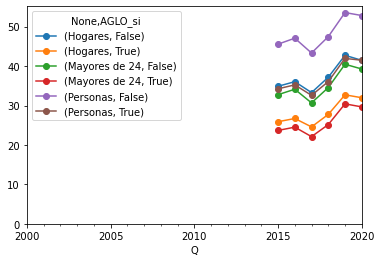

In [18]:
df = cuadro3['Pobreza']['mean'].unstack()
df = df.groupby(pd.Grouper(level = 0, freq='Y')).mean()

df.plot(marker = 'o')
plt.xlim(30, )
plt.ylim(0, )

In [ ]:
xx

In [ ]:
from IPython.display import display, HTML

for porcentajes in [False, True]:

    for area_columns in [['NOMPROV'], ['Region','NOMAGLO'], ['AGLO_si']]: #['P0910']
#     for area_columns in [['NOMDPTO']]:
#     for area_columns in [['Total pais']]:

        result_list = []
    
        # Lista con los datasets. En el proximo loop se crean los cuadros...
        for q in CB_ipc.Q.astype(str).unique():
            if q not in ['2015-09-30', '2015-12-31', '2016-03-31', '2018-12-31']: # Los trimestres que faltan
                print(q)
                df = pd.read_csv('./../data/info/RFReg_'+str(frac)+'ARG'+q+'.csv',
                                 usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'RADIO_REF_ID', 'CONDACT','P47T', 'P03','P02', 'P09','P10', 'DPTO', 'AGLOMERADO'])
                
                # FILTRAR SI ES NECESARIO
                df = df.loc[df.AGLOMERADO.isin([33, 32, 2])]
                
                
                df['Q'] = pd.to_datetime(q, infer_datetime_format = True)
                df['P10'] = 2 - df['P10']
                df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 
                df['P0910'] = df.P09.astype(str) + df.P10.astype(str)

                df_cb = df.merge(DPTO_Region)
                df_cb = df_cb.merge(ad_eq)
                df_cb = df_cb.merge(CB_ipc)

                df_cb_hogares = df_cb.groupby('HOGAR_REF_ID')[['P47T','CBA', 'CBT']].sum()
                df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
                df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
                pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT','Pobreza', 'Indigencia']].reset_index()
                pobreza_hogares['gap'] = pobreza_hogares.P47T - pobreza_hogares.CBT
                pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

#                 df = df.sample(20000)

                df = df.rename(columns = {'P47T': 'P47T_persona'})
                data = df.merge(pobreza_hogares, on = 'HOGAR_REF_ID', how = 'left') 
                print(data.shape)
                data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'DPTO', 'AGLOMERADO'])
                print(data.shape)
                data['AGLO_si'] = data.AGLOMERADO != 0

            # EDITAR ACA
            data['Total pais'] = 'Si'
            result = cuadro_resumen_por_area(data, area_columns)

            if porcentajes: #resultados en porc.
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['mean', 'median'])]
                s = 'pct'
            else: #resultados en cantidades
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['sum', 'median'])]
                s = 'n'

            pct.columns = pct.columns.droplevel(1)

            r = pct.sort_index(1).sort_values(by = ('Pobreza', 'Personas'))

            #add quarter column
            r = r.set_index(np.repeat(data.Q.unique()[0], r.shape[0]), append=True)
            r.index.names = [area_columns + ['Q']][0]

            result_list += [r]

        cuadro = pd.concat(result_list)

        file = './data/cuadro_'+str(frac)+'_'+'_'.join(area_columns).replace(' ', '_')+'_Q_'+s+'_ARG'
        print(file)
        display(cuadro.head())
        cuadro.to_csv(file)

In [ ]:
# df.merge(pobreza_hogares, on = 'HOGAR_REF_ID', how = 'left')
df.nunique()

In [ ]:
pobreza_hogares.nunique()

In [ ]:
from IPython.display import display, HTML

for porcentajes in [False, True]:

#     for area_columns in [['NOMPROV'], ['Region','NOMAGLO'], ['AGLO_si']]: #['P0910']
#     for area_columns in [['NOMDPTO']]:
    for area_columns in [['Total pais']]:

        result_list = []
    
        # Lista con los datasets. En el proximo loop se crean los cuadros...
        for q in CB_ipc.Q.astype(str).unique():
            if q not in ['2015-09-30', '2015-12-31', '2016-03-31', '2018-12-31']: # Los trimestres que faltan
                print(q)
                df = pd.read_csv('./../data/info/RFReg_'+str(frac)+'ARG'+q+'.csv',
                                 usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'RADIO_REF_ID', 'CONDACT','P47T', 'P03','P02', 'P09','P10', 'DPTO', 'AGLOMERADO'])
                
#                 # FILTRAR SI ES NECESARIO
#                 df = df.loc[df.AGLOMERADO.isin([33, 32, 2])]
                
                
                df['Q'] = pd.to_datetime(q, infer_datetime_format = True)
                df['P10'] = 2 - df['P10']
                df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 
                df['P0910'] = df.P09.astype(str) + df.P10.astype(str)

                df_cb = df.merge(DPTO_Region)
                df_cb = df_cb.merge(ad_eq)
                df_cb = df_cb.merge(CB_ipc)

                df_cb_hogares = df_cb.groupby('HOGAR_REF_ID')[['P47T','CBA', 'CBT']].sum()
                df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
                df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
                pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT','Pobreza', 'Indigencia']].reset_index()
                pobreza_hogares['gap'] = pobreza_hogares.P47T - pobreza_hogares.CBT
                pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

#                 df = df.sample(20000)

                df = df.rename(columns = {'P47T': 'P47T_persona'})
                data = df.merge(pobreza_hogares, on = 'HOGAR_REF_ID', how = 'left') 
                print(data.shape)
                data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'DPTO', 'AGLOMERADO'])
                print(data.shape)
                data['AGLO_si'] = data.AGLOMERADO != 0

            # EDITAR ACA
            data['Total pais'] = 'Si'
            result = cuadro_resumen_por_area(data, area_columns)

            if porcentajes: #resultados en porc.
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['mean', 'median'])]
                s = 'pct'
            else: #resultados en cantidades
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['sum', 'median'])]
                s = 'n'

            pct.columns = pct.columns.droplevel(1)

            r = pct.sort_index(1).sort_values(by = ('Pobreza', 'Personas'))

            #add quarter column
            r = r.set_index(np.repeat(data.Q.unique()[0], r.shape[0]), append=True)
            r.index.names = [area_columns + ['Q']][0]

            result_list += [r]

        cuadro = pd.concat(result_list)

        file = './data/cuadro_'+str(frac)+'_'+'_'.join(area_columns).replace(' ', '_')+'_Q_'+s+'_ARG'
        print(file)
        display(cuadro.head())
        cuadro.to_csv(file)

In [ ]:
from IPython.display import display, HTML

for porcentajes in [False, True]:

    for area_columns in [['NOMPROV'], ['Region','NOMAGLO'], ['AGLO_si']]: #['P0910']
#     for area_columns in [['NOMDPTO']]:
#     for area_columns in [['Total pais']]:

        result_list = []
    
        # Lista con los datasets. En el proximo loop se crean los cuadros...
        for q in CB_ipc.Q.astype(str).unique():
            if q not in ['2015-09-30', '2015-12-31', '2016-03-31', '2018-12-31']: # Los trimestres que faltan
                print(q)
                df = pd.read_csv('./../data/info/RFReg_'+str(frac)+'ARG'+q+'.csv',
                                 usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'RADIO_REF_ID', 'CONDACT','P47T', 'P03','P02', 'P09','P10', 'DPTO', 'AGLOMERADO'])
                
#                 # FILTRAR SI ES NECESARIO
#                 df = df.loc[df.AGLOMERADO.isin([33, 32, 2])]
                
                
                df['Q'] = pd.to_datetime(q, infer_datetime_format = True)
                df['P10'] = 2 - df['P10']
                df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 
                df['P0910'] = df.P09.astype(str) + df.P10.astype(str)

                df_cb = df.merge(DPTO_Region)
                df_cb = df_cb.merge(ad_eq)
                df_cb = df_cb.merge(CB_ipc)

                df_cb_hogares = df_cb.groupby('HOGAR_REF_ID')[['P47T','CBA', 'CBT']].sum()
                df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
                df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
                pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT','Pobreza', 'Indigencia']].reset_index()
                pobreza_hogares['gap'] = pobreza_hogares.P47T - pobreza_hogares.CBT
                pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

#                 df = df.sample(20000)

                df = df.rename(columns = {'P47T': 'P47T_persona'})
                data = df.merge(pobreza_hogares, on = 'HOGAR_REF_ID', how = 'left') 
                print(data.shape)
                data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'DPTO', 'AGLOMERADO'])
                print(data.shape)
                data['AGLO_si'] = data.AGLOMERADO != 0

            # EDITAR ACA
            data['Total pais'] = 'Si'
            result = cuadro_resumen_por_area(data, area_columns)

            if porcentajes: #resultados en porc.
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['mean', 'median'])]
                s = 'pct'
            else: #resultados en cantidades
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['sum', 'median'])]
                s = 'n'

            pct.columns = pct.columns.droplevel(1)

            r = pct.sort_index(1).sort_values(by = ('Pobreza', 'Personas'))

            #add quarter column
            r = r.set_index(np.repeat(data.Q.unique()[0], r.shape[0]), append=True)
            r.index.names = [area_columns + ['Q']][0]

            result_list += [r]

        cuadro = pd.concat(result_list)

        file = './data/cuadro_'+str(frac)+'_'+'_'.join(area_columns).replace(' ', '_')+'_Q_'+s+'_ARG'
        print(file)
        display(cuadro.head())
        cuadro.to_csv(file)

In [ ]:
data_list = []
frac = 0.02

# Lista con los datasets. En el proximo loop se crean los cuadros...
for q in CB_ipc.Q.astype(str).unique():
    if q not in ['2015-09-30', '2015-12-31', '2016-03-31', '2018-12-31']: # Los trimestres que faltan
        df = pd.read_csv('./../data/info/RFReg_'+str(frac)+'ARG'+q+'.csv',
                         usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID', 'RADIO_REF_ID', 'CONDACT','P47T', 'P03','P02', 'P09','P10', 'DPTO'])

        df['Q'] = pd.to_datetime(q, infer_datetime_format = True)
        df['P10'] = 2 - df['P10']
        df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 
        df['P0910'] = df.P09.astype(str) + df.P10.astype(str)

        df_cb = df.merge(DPTO_Region)
        df_cb = df_cb.merge(ad_eq)
        df_cb = df_cb.merge(CB_ipc)

        df_cb_hogares = df_cb.groupby('HOGAR_REF_ID')[['P47T','CBA', 'CBT']].sum()
        df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
        df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
        pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT','Pobreza', 'Indigencia']].reset_index()
        pobreza_hogares['gap'] = pobreza_hogares.P47T - pobreza_hogares.CBT
        pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

    #     df = df.sample(20000)

        df = df.rename(columns = {'P47T': 'P47T_persona'})
        data = df.merge(pobreza_hogares, on = 'HOGAR_REF_ID', how = 'left') 
        print(data.shape)
        data = data.merge(radio_ref, on = ['RADIO_REF_ID', 'DPTO'])
        print(data.shape)
        data['AGLO_si'] = data.AGLOMERADO != 0


        # Quedarse solo con poblacion de AGLOMERADOS
    #     df = df.loc[df.AGLOMERADO != 0]

        data_list += [data]

    #data = pd.concat(data_list)

## Generar cuadros

In [ ]:
# data.columns

In [ ]:
# result

In [ ]:
from IPython.display import display, HTML

for porcentajes in [False, True]:

#     for area_columns in [['NOMPROV'], ['Region','NOMAGLO'], ['AGLO_si']]: #['P0910']
    for area_columns in [['NOMDPTO']]:
#     for area_columns in [['Total pais']]:

        result_list = []
        for data in data_list:
            data['Total pais'] = 'Si'
            result = cuadro_resumen_por_area(data.loc[data.AGLOMERADO.isin([33, 32, 2])], area_columns)
#             result = cuadro_resumen_por_area(data, area_columns)

            if porcentajes: #resultados en porc.
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['mean', 'median'])]
                s = 'pct'
            else: #resultados en cantidades
                pct = result.iloc[:, result.columns.get_level_values(1).isin(['sum', 'median'])]
                s = 'n'

            pct.columns = pct.columns.droplevel(1)

            r = pct.sort_index(1).sort_values(by = ('Pobreza', 'Personas'))

            #add quarter column
            r = r.set_index(np.repeat(data.Q.unique()[0], r.shape[0]), append=True)
            r.index.names = [area_columns + ['Q']][0]

            result_list += [r]

        cuadro = pd.concat(result_list)

        file = './data/cuadro_'+str(frac)+'_'+'_'.join(area_columns).replace(' ', '_')+'_Q_'+s+'_ARG'
        print(file)
        display(cuadro.head())
        cuadro.to_csv(file)

In [ ]:
xx

In [ ]:
# result = cuadro_resumen_por_area(['Region','NOMAGLO'])
result = cuadro_resumen_por_area(['AGLO_si'])
# result = cuadro_resumen_por_area(['NOMPROV'])



In [ ]:
result
# '_'.join(['Region'])

## Plot and save dependencia temporal

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# for d in data_list:
#     print(d.mean())
fig, ax = plt.subplots(1, figsize = (8, 5))

data.groupby('Q')[['Pobreza', 'Indigencia']].mean().plot(ax = ax, legend = False)
(data.groupby('Q')[['P47T_persona']].mean()/40000).plot(ax = ax,  legend = False)
plt.xticks(rotation=90)
plt.show()

In [ ]:
data.nunique()

In [ ]:

df1 = data.set_index('Q').groupby(pd.Grouper(level = 0, freq = '6M')).agg({'PERSONA_REF_ID': ['nunique', 'count'], 'P47T_persona': ['mean', 'median'],
                                     'P47T_hogar': ['mean', 'median'],
                                    'CBA': 'median', 'CBT': 'median',
                                    'Pobreza': 'sum', 'Indigencia': 'sum',
                                    'gap': ['mean', 'median']}).round()

df2 = data.set_index('Q').groupby(pd.Grouper(level = 0, freq = '6M')).agg({'Pobreza': ['mean'], 'Indigencia': ['mean']}).round(4)

tabla_semestral = pd.concat([df1, df2], axis = 1)
tabla_semestral.to_csv('./data/tabla_semestral_AGLOS_'+str(frac)+'.csv')
tabla_semestral

In [ ]:
# for d in data_list:
#     print(d.mean())
fig, ax = plt.subplots(1, figsize = (8, 5))

data.groupby('Q')[['Pobreza', 'Indigencia']].mean().plot(ax = ax)
(data.groupby('Q')[['P47T_persona']].mean()/40000).plot(ax = ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# frac = 0.01
# for q in ['2018-06-30', '2016-06-30']:
#     data_q = data.loc[data.Q == q]
    
# #     for cat in cat_cols[-1:]:
#     cat = 'Grupo Etario'
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
#     info = data_q.groupby([cat, 'Pobreza'])[['PERSONA_REF_ID', 'HOGAR_REF_ID']].nunique()
#     info_pct = (100*(info.unstack()/info.unstack().sum()).stack())
#     sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=info_pct.reset_index(), ax = ax1)
#     xlab = ''
#     try:
#         xlab = vn.loc[vn.Censo == cat]['Pregunta'].values[0]
#     except:
#         try:
#             xlab = vn.loc[vn.EPH == cat]['Pregunta'].values[0]
#         except:
#             pass
#     ax1.set(xlabel= xlab, ylabel = 'porcentaje de PERSONAS')
#     ax1.tick_params(axis='x', rotation=90)
#     sns.barplot(x=cat, y="PERSONA_REF_ID", hue="Pobreza", data=info.reset_index(), ax = ax2)
#     ax2.set(xlabel= xlab, ylabel = 'porcentaje de HOGARES \n con alguien')
#     ax2.tick_params(axis='x', rotation=90)
#     plt.show()

In [ ]:

# df = pd.read_csv('./../data/info/ARG_'+str(frac)+'_income_YQ_deflac.csv')

# indice_precios = pd.read_csv('./../data/info/indice_pricestats_YQ.csv', index_col=0)
# indice_precios.index = pd.DatetimeIndex(indice_precios.index)
# indice_precios.index.name = 'Q'

# # El indice nos da los valores en pesos para cualquier trimestre. El ultimo es 3er trimestre 2018
# inx = indice_precios.tail(1).values[0][0]
# df['P47T'] = inx*df['P47T']